In [64]:
import torch
from torchvision import models
import os
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, transform
from PIL import Image
from sklearn.metrics import r2_score, mean_squared_error

In [65]:
class EggShellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data_frame.iloc[idx, 0]
        #image = io.imread(img_name)
        image = Image.open(img_name).convert('L')
        measurements = self.data_frame.iloc[idx, 1:].values.astype('float')
        sample = {'image': image, 'measurements': measurements}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [66]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, measurements = sample['image'], sample['measurements']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # Verificando e ajustando as dimensões da imagem para ter 3 canais (RGB)
        if len(img.shape) < 3:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)

        return {'image': img, 'measurements': measurements}

In [67]:
class ToTensor(object):
    def __call__(self, sample):
        image, measurements = sample['image'], sample['measurements']

        # Adicionando um canal para as imagens (para o PyTorch)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(), 'measurements': torch.from_numpy(measurements).float()}

In [68]:
data_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [69]:
train_dataset = EggShellDataset(csv_file='imagem/train.csv', root_dir='imagem/', transform=data_transform)
test_dataset = EggShellDataset(csv_file='imagem/test.csv', root_dir='imagem/', transform=data_transform)

# Definindo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [70]:
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv = models.vgg16(pretrained=True).features
        
        # Substituir a primeira camada convolucional para aceitar um canal (escala de cinza)
        self.conv[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [71]:
# class EggShellCNN(nn.Module):
#     def __init__(self):
#         super(EggShellCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64 * 64 * 64, 128)
#         self.fc2 = nn.Linear(128, 5)  # 5 saídas para as medidas

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = x.view(-1, 64 * 64 * 64)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [72]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128 * 53 * 53, 4096)  # Ajuste esta dimensão conforme necessário
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x


In [73]:
#model = EggShellCNN()

model = CNNRegression()

#model = Net()
# Definindo a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
def adjusted_r2(y_test, y_pred, X_train):
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / 
              (len(y_test) - X_train.shape[1] - 1))
    return adj_r2

In [75]:
num_epochs = 10

train_losses = []
train_r2_scores = []
train_rmse_scores = []

for epoch in range(num_epochs):
    running_loss = 0.0

    epoch_r2_scores = []
    epoch_rmse_scores = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['measurements']
        inputs = inputs[:,:1,:,:]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        predicted = outputs.detach().numpy()
        actual = labels.numpy()
        epoch_r2_score = adjusted_r2(actual,predicted, inputs)
        epoch_r2_scores.append(epoch_r2_score)

        mse = mean_squared_error(actual, predicted)
        rmse = mse**0.5
        epoch_rmse_scores.append(rmse)

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    mean_epoch_r2_score = np.mean(epoch_r2_scores)
    train_r2_scores.append(mean_epoch_r2_score)

    mean_epoch_rmse_score = np.mean(epoch_rmse_scores)
    train_rmse_scores.append(mean_epoch_rmse_score)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Adjusted R2 Socre: {epoch_r2_score}, RMSE: {mean_epoch_rmse_score}')

    #print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

Epoch 1, Loss: 223846.3230102539, Adjusted R2 Socre: -1235.7394584489252, RMSE: 237.52832607135207
Epoch 2, Loss: 675.1770629882812, Adjusted R2 Socre: -233.56373573083744, RMSE: 24.677357630565847
Epoch 3, Loss: 630.3544311523438, Adjusted R2 Socre: -793.7092997718282, RMSE: 24.85952480124947
Epoch 4, Loss: 482.0367126464844, Adjusted R2 Socre: -2318.8115201211135, RMSE: 21.862148267091882
Epoch 5, Loss: 318.25022888183594, Adjusted R2 Socre: -342.354682341039, RMSE: 17.638643118755517
Epoch 6, Loss: 230.9996124267578, Adjusted R2 Socre: -158.33092465059408, RMSE: 15.160053649723562
Epoch 7, Loss: 220.43780212402345, Adjusted R2 Socre: -2065.9512695735307, RMSE: 14.777544581777892
Epoch 8, Loss: 121.13965301513672, Adjusted R2 Socre: -152.70577380399018, RMSE: 10.9583277525164
Epoch 9, Loss: 117.54316711425781, Adjusted R2 Socre: -172.397847090377, RMSE: 10.757186717238952
Epoch 10, Loss: 112.99426879882813, Adjusted R2 Socre: -137.8944047254007, RMSE: 10.61091717788444
Finished Train

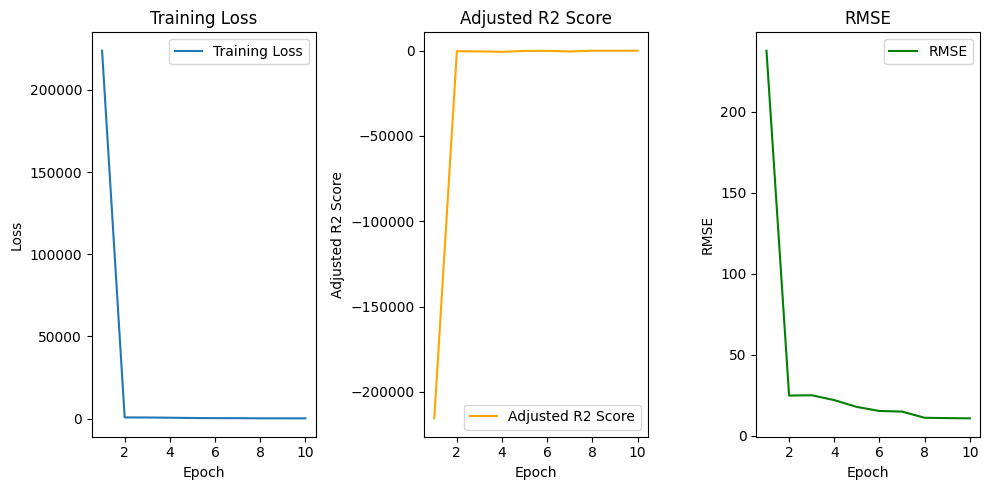

In [76]:
num_epochs = len(train_losses)
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotando a perda
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotando o R2 score ajustado
plt.subplot(1, 3, 2)
plt.plot(epochs, train_r2_scores, label='Adjusted R2 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Adjusted R2 Score')
plt.title('Adjusted R2 Score')
plt.legend()

# Plotando o RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse_scores, label='RMSE', color='green')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
model.eval()
total_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data['image'], data['measurements']
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        total_loss += loss.item()

print(f'Average Test Loss: {total_loss / len(test_loader)}')

Average Test Loss: 94.95005798339844
